## Import Library

In [1]:
import numpy as np
import pandas as pd

import openslide
import os
import cv2
import PIL
from IPython.display import Image, display
from keras.applications.vgg16 import VGG16,preprocess_input

import plotly.graph_objs as go
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,BatchNormalization,Activation
from keras.layers import GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
import gc
import matplotlib.pyplot as plt
import skimage.io
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.python.keras import backend as K
sess = K.get_session()

Using TensorFlow backend.


## Pre-Processing

In [2]:
from numpy.random import seed
seed(1)

In [3]:
train=pd.read_csv('/kaggle/input/prostate-cancer-grade-assessment/train.csv')
train.head()
train_copy = train.copy()

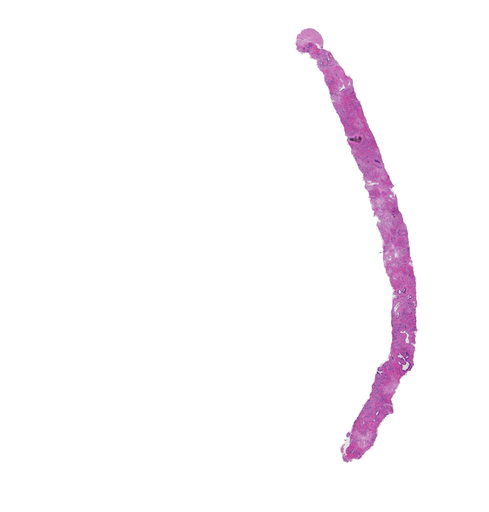

In [4]:
img=openslide.OpenSlide('/kaggle/input/prostate-cancer-grade-assessment/train_images/2fd1c7dc4a0f3a546a59717d8e9d28c3.tiff')
display(img.get_thumbnail(size=(512,512)))

In [5]:
img.dimensions

(27648, 28928)

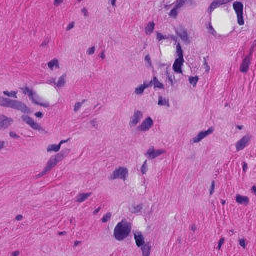

In [6]:
patch = img.read_region((18500,4100), 0, (256, 256))

# Display the image
display(patch)
# Close the opened slide after use
img.close()

In [7]:
train['isup_grade'].value_counts()

0    2892
1    2666
2    1343
4    1249
3    1242
5    1224
Name: isup_grade, dtype: int64

In [8]:
labels=[]
data=[]
data_dir='/kaggle/input/panda-resized-train-data-512x512/train_images/train_images/'
for i in range(train.shape[0]):
    data.append(data_dir + train['image_id'].iloc[i]+'.png')
    labels.append(train['isup_grade'].iloc[i])
df=pd.DataFrame(data)
df.columns=['images']
df['isup_grade']=labels

## Train/Test Split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(df['images'],df['isup_grade'], test_size=0.1, random_state=42)


In [10]:
train=pd.DataFrame(X_train)
train.columns=['images']
train['isup_grade']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['isup_grade']=y_val

train['isup_grade']=train['isup_grade'].astype(str)
validation['isup_grade']=validation['isup_grade'].astype(str)

## Preparing Data

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40,
    featurewise_center=True,
    featurewise_std_normalization=True,       
    horizontal_flip=True, vertical_flip = True,
    brightness_range=[0.9, 1.1],
    width_shift_range=1.0,
    height_shift_range=1.0)

val_datagen=train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='isup_grade',
    target_size=(224, 224),
    batch_size=32,
    shuffle = True,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='isup_grade',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 9554 validated image filenames belonging to 6 classes.
Found 1062 validated image filenames belonging to 6 classes.


In [12]:
filenames = validation_generator.filenames
nb_samples = len(filenames)

## VGG19 Model

In [13]:
from keras.applications.vgg19 import VGG19
def vgg19_model(num_classes = None):
    model = VGG19(weights='/kaggle/input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))
    x=Dropout(0.3)(model.output)
    x=Flatten()(x)
    x =Dense(32, activation = 'relu')(x)
    x =Dropout(0.2)(x)
    output=Dense(num_classes,activation='softmax')(x)
    model=Model(model.input,output)
    return model
vgg19_conv = vgg19_model(6)

## InceptionV3 Model

In [14]:
from keras.applications.inception_v3 import InceptionV3
def InceptionV3_model(num_classes = None):
    InceptionV3_weights = '../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    model = InceptionV3(weights= InceptionV3_weights, include_top=False, input_shape=(224, 224, 3))
    x=Dropout(0.3)(model.output)
    x=Flatten()(x)
    x =Dense(32, activation = 'relu')(x)
    x =Dropout(0.2)(x)
    output=Dense(num_classes,activation='softmax')(x)
    model=Model(model.input,output)
    return model
InceptionV3_conv = InceptionV3_model(6)

## ResNet50 Model

In [15]:
from keras.applications.resnet50 import ResNet50
def ResNet50_model(num_classes = None):
    ResNet_weights = '/kaggle/input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    model = ResNet50(weights= ResNet_weights, include_top=False, input_shape=(224, 224, 3))
    x=Flatten()(model.output)
    x =Dense(16, activation = 'relu')(x)
    x =Dropout(0.2)(x)
    output=Dense(num_classes,activation='softmax')(x)
    model=Model(model.input,output)
    return model
ResNet50_conv = ResNet50_model(6)

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning:

The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.



## DenseNet Model

In [16]:
from keras.applications import DenseNet121
def Densenet_model(num_classes = None):
    Densenet_weights = '/kaggle/input/densenet-keras/DenseNet-BC-121-32-no-top.h5'
    model = DenseNet121(weights= Densenet_weights, include_top=False, input_shape=(224, 224, 3))
    x=Flatten()(model.output)
    x =Dense(16, activation = 'relu')(x)
    x =Dropout(0.2)(x)
    output=Dense(num_classes,activation='softmax')(x)
    model=Model(model.input,output)
    return model
Densenet_conv = Densenet_model(6)

## Including batch Normalization

In [17]:
def freeze(model):
    for layer in model.layers[:99]:
        layer.trainable = False
        if layer.name.startswith('batch_normalization'):
            layer.trainable = True
        if layer.name.endswith('bn'):
            layer.trainable = True
    for layer in model.layers[99:]:
        layer.trainable = True

## Kappa Score

In [19]:
def kappa_score(y_true, y_pred):
    
    y_true=tf.math.argmax(y_true)
    y_pred=tf.math.argmax(y_pred)
    return tf.compat.v1.py_func(cohen_kappa_score,(y_true,y_pred),tf.double)

In [20]:
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import keras.backend as K
import tensorflow as tf

def kappa_keras(y_true, y_pred):

    y_true = K.cast(K.argmax(y_true, axis=-1), dtype='int32')
    y_pred = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
    min_rating = K.minimum(K.min(y_true), K.min(y_pred))
    max_rating = K.maximum(K.max(y_true), K.max(y_pred))

    y_true = K.map_fn(lambda y: y - min_rating, y_true, dtype='int32')
    y_pred = K.map_fn(lambda y: y - min_rating, y_pred, dtype='int32')

    # Build the observed/confusion matrix
    num_ratings = max_rating - min_rating + 1
    observed = tf.math.confusion_matrix(y_true, y_pred,
                                num_classes=num_ratings)
    num_scored_items = K.shape(y_true)[0]

    weights = K.expand_dims(K.arange(num_ratings), axis=-1) - K.expand_dims(K.arange(num_ratings), axis=0)
    weights = K.cast(K.pow(weights, 2), dtype='float64')

    hist_true = tf.math.bincount(y_true, minlength=num_ratings)
    hist_true = hist_true[:num_ratings] / num_scored_items
    hist_pred = tf.math.bincount(y_pred, minlength=num_ratings)
    hist_pred = hist_pred[:num_ratings] / num_scored_items
    expected = K.dot(K.expand_dims(hist_true, axis=-1), K.expand_dims(hist_pred, axis=0))

    # Normalize observed array
    observed = observed / num_scored_items

    # If all weights are zero, that means no disagreements matter.
    score = tf.where(K.any(K.not_equal(weights, 0)), 
                     K.sum(weights * observed) / K.sum(weights * expected), 
                     0)
    
    return 1. - score

## Hyperparameter

In [21]:
opt = SGD(lr= 0.0005, momentum=0.9,decay=1e-4)
vgg19_conv.compile(loss='binary_crossentropy',optimizer=opt,metrics=[kappa_score,kappa_keras, 'accuracy'])
InceptionV3_conv.compile(loss='binary_crossentropy',optimizer=opt,metrics=[kappa_score,kappa_keras,'accuracy'])
ResNet50_conv.compile(loss='binary_crossentropy',optimizer=opt,metrics=[kappa_score,kappa_keras, 'accuracy'])
Densenet_conv.compile(loss='binary_crossentropy',optimizer=opt,metrics=[kappa_score,kappa_keras,'accuracy'])

In [22]:
nb_epochs = 20
batch_size=16
nb_train_steps = train.shape[0]//batch_size
nb_val_steps=validation.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps,nb_val_steps))

Number of training and validation steps: 597 and 66


In [23]:
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

## Train Model

In [24]:
hist_vgg19 = vgg19_conv.fit_generator( train_generator,steps_per_epoch=nb_train_steps,epochs=nb_epochs,validation_data=validation_generator,
                                      validation_steps=nb_val_steps,callbacks = callbacks)

Epoch 1/20
597/597 [==============================] - 236s 395ms/step - loss: 0.4277 - kappa_score: 0.0167 - kappa_keras: 0.1701 - accuracy: 0.8329 - val_loss: 0.3851 - val_kappa_score: 0.0373 - val_kappa_keras: 0.3782 - val_accuracy: 0.8333
Epoch 2/20
597/597 [==============================] - 180s 301ms/step - loss: 0.4070 - kappa_score: 0.0296 - kappa_keras: 0.3794 - accuracy: 0.8353 - val_loss: 0.4308 - val_kappa_score: 0.0277 - val_kappa_keras: 0.4682 - val_accuracy: 0.8360
Epoch 3/20
597/597 [==============================] - 180s 301ms/step - loss: 0.3947 - kappa_score: 0.0465 - kappa_keras: 0.4301 - accuracy: 0.8397 - val_loss: 0.4000 - val_kappa_score: 0.0230 - val_kappa_keras: 0.4101 - val_accuracy: 0.8399
Epoch 4/20
597/597 [==============================] - 178s 297ms/step - loss: 0.3852 - kappa_score: 0.0476 - kappa_keras: 0.4657 - accuracy: 0.8426 - val_loss: 0.3605 - val_kappa_score: 0.0303 - val_kappa_keras: 0.4737 - val_accuracy: 0.8400
Epoch 5/20
597/597 [============

In [25]:
hist_Resnet = ResNet50_conv.fit_generator( train_generator,steps_per_epoch=nb_train_steps,epochs=nb_epochs,validation_data=validation_generator,
                                          validation_steps=nb_val_steps, callbacks = callbacks)

Epoch 1/20
597/597 [==============================] - 238s 399ms/step - loss: 0.4152 - kappa_score: 0.0246 - kappa_keras: 0.2252 - accuracy: 0.8389 - val_loss: 0.4510 - val_kappa_score: 0.0105 - val_kappa_keras: 0.0032 - val_accuracy: 0.8293
Epoch 2/20
597/597 [==============================] - 226s 378ms/step - loss: 0.3706 - kappa_score: 0.0678 - kappa_keras: 0.4018 - accuracy: 0.8540 - val_loss: 0.4353 - val_kappa_score: 0.0308 - val_kappa_keras: 0.2813 - val_accuracy: 0.8358
Epoch 3/20
597/597 [==============================] - 223s 373ms/step - loss: 0.3307 - kappa_score: 0.0972 - kappa_keras: 0.5124 - accuracy: 0.8694 - val_loss: 0.4310 - val_kappa_score: 0.0554 - val_kappa_keras: 0.4033 - val_accuracy: 0.8356
Epoch 4/20
597/597 [==============================] - 226s 378ms/step - loss: 0.2925 - kappa_score: 0.1273 - kappa_keras: 0.6068 - accuracy: 0.8838 - val_loss: 0.4916 - val_kappa_score: 0.0457 - val_kappa_keras: 0.4830 - val_accuracy: 0.8338
Epoch 5/20
597/597 [============

In [26]:
hist_Densenet =Densenet_conv.fit_generator( train_generator,steps_per_epoch=nb_train_steps,epochs=nb_epochs,validation_data=validation_generator,
                                           validation_steps=nb_val_steps, callbacks = callbacks)

Epoch 1/20
597/597 [==============================] - 333s 557ms/step - loss: 0.4402 - kappa_score: 0.0094 - kappa_keras: 0.0472 - accuracy: 0.8338 - val_loss: 0.4324 - val_kappa_score: 0.0128 - val_kappa_keras: 0.0956 - val_accuracy: 0.8347
Epoch 2/20
597/597 [==============================] - 284s 475ms/step - loss: 0.4120 - kappa_score: 0.0292 - kappa_keras: 0.1830 - accuracy: 0.8396 - val_loss: 0.3960 - val_kappa_score: 0.0288 - val_kappa_keras: 0.2495 - val_accuracy: 0.8394
Epoch 3/20
597/597 [==============================] - 286s 480ms/step - loss: 0.3906 - kappa_score: 0.0544 - kappa_keras: 0.2885 - accuracy: 0.8461 - val_loss: 0.4229 - val_kappa_score: 0.0407 - val_kappa_keras: 0.3081 - val_accuracy: 0.8382
Epoch 4/20
597/597 [==============================] - 283s 473ms/step - loss: 0.3692 - kappa_score: 0.0828 - kappa_keras: 0.3693 - accuracy: 0.8532 - val_loss: 0.4815 - val_kappa_score: 0.0719 - val_kappa_keras: 0.3720 - val_accuracy: 0.8368
Epoch 5/20
597/597 [============

In [27]:
hist_Inception = InceptionV3_conv.fit_generator( train_generator,steps_per_epoch=nb_train_steps,epochs=nb_epochs,validation_data=validation_generator,
                            validation_steps=nb_val_steps, callbacks = callbacks)

Epoch 1/20
597/597 [==============================] - 195s 327ms/step - loss: 0.4393 - kappa_score: 0.0114 - kappa_keras: 0.0664 - accuracy: 0.8308 - val_loss: 0.4092 - val_kappa_score: 0.0127 - val_kappa_keras: 0.0363 - val_accuracy: 0.8332
Epoch 2/20
597/597 [==============================] - 179s 300ms/step - loss: 0.4204 - kappa_score: 0.0276 - kappa_keras: 0.1149 - accuracy: 0.8338 - val_loss: 0.4434 - val_kappa_score: 0.0111 - val_kappa_keras: 0.0736 - val_accuracy: 0.8328
Epoch 3/20
597/597 [==============================] - 167s 280ms/step - loss: 0.4115 - kappa_score: 0.0273 - kappa_keras: 0.1907 - accuracy: 0.8360 - val_loss: 0.4491 - val_kappa_score: 0.0396 - val_kappa_keras: 0.2128 - val_accuracy: 0.8343
Epoch 4/20
597/597 [==============================] - 167s 280ms/step - loss: 0.4022 - kappa_score: 0.0392 - kappa_keras: 0.3008 - accuracy: 0.8383 - val_loss: 0.4343 - val_kappa_score: 0.0382 - val_kappa_keras: 0.2749 - val_accuracy: 0.8345
Epoch 5/20
597/597 [============

## Result

In [28]:
l_incep = InceptionV3_conv.evaluate(validation_generator,verbose = 2)[0]
k_incep = InceptionV3_conv.evaluate(validation_generator,verbose = 2)[2]
acc_incep = InceptionV3_conv.evaluate(validation_generator,verbose = 2)[3]

In [29]:
l_vgg = vgg19_conv.evaluate(validation_generator,verbose = 2)[0]
k_vgg = vgg19_conv.evaluate(validation_generator,verbose = 2)[2]
acc_vgg = vgg19_conv.evaluate(validation_generator,verbose = 2)[3]

In [30]:
l_res = ResNet50_conv.evaluate(validation_generator,verbose = 2)[0]
k_res = ResNet50_conv.evaluate(validation_generator,verbose = 2)[2]
acc_res = ResNet50_conv.evaluate(validation_generator,verbose = 2)[3]

In [31]:
l_den = Densenet_conv.evaluate(validation_generator,verbose = 2)[0]
k_den = Densenet_conv.evaluate(validation_generator,verbose = 2)[2]
acc_den = Densenet_conv.evaluate(validation_generator,verbose = 2)[3]

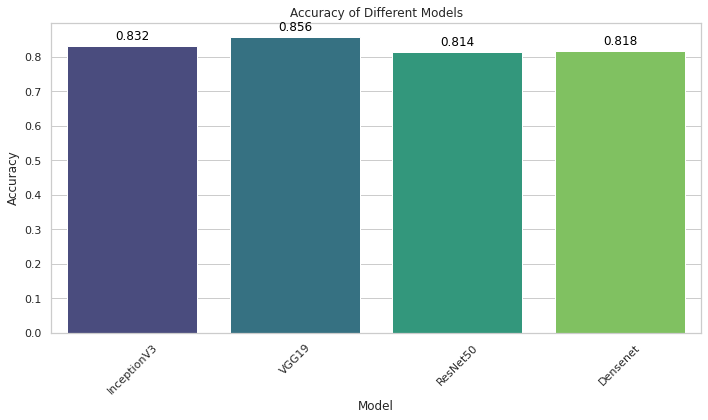

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'Model': ['InceptionV3', 'VGG19', 'ResNet50', 'Densenet'],
    'Accuracy': [acc_incep, acc_vgg, acc_res, acc_den]
}
df = pd.DataFrame(data)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                fontsize=12, color='black', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

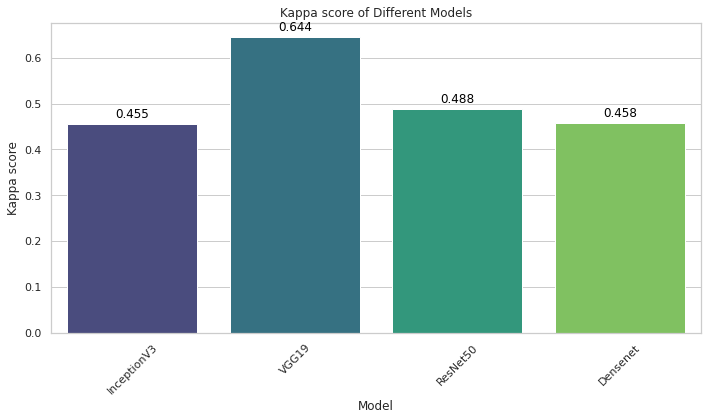

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'Model': ['InceptionV3', 'VGG19', 'ResNet50', 'Densenet'],
    'Kappa Score': [k_incep, k_vgg, k_res, k_den]
}
df = pd.DataFrame(data)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Kappa Score', data=df, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                fontsize=12, color='black', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Model')
plt.ylabel('Kappa score')
plt.title('Kappa score of Different Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

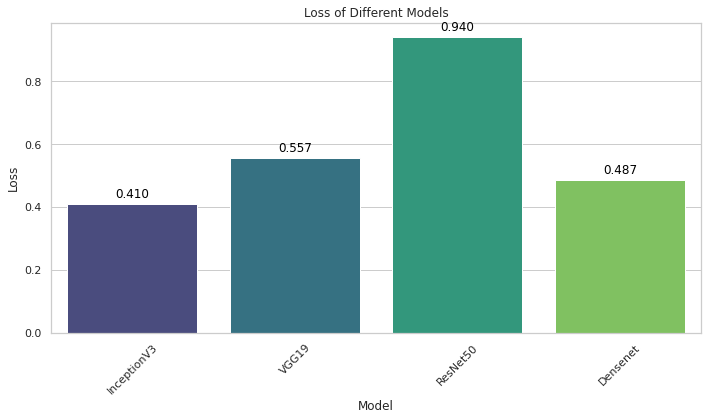

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'Model': ['InceptionV3', 'VGG19', 'ResNet50', 'Densenet'],
    'Loss': [l_incep, l_vgg, l_res, l_den]
}
df = pd.DataFrame(data)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Loss', data=df, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                fontsize=12, color='black', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Loss of Different Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
def show_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('kappa_keras')
    ax[1].plot(history.epoch, history.history["kappa_keras"], label="Train Quadratic Kappa score")
    ax[1].plot(history.epoch, history.history["val_kappa_keras"], label="Validation Quadratic Kappa score")
    ax[2].set_title('accuracy')
    ax[2].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[2].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

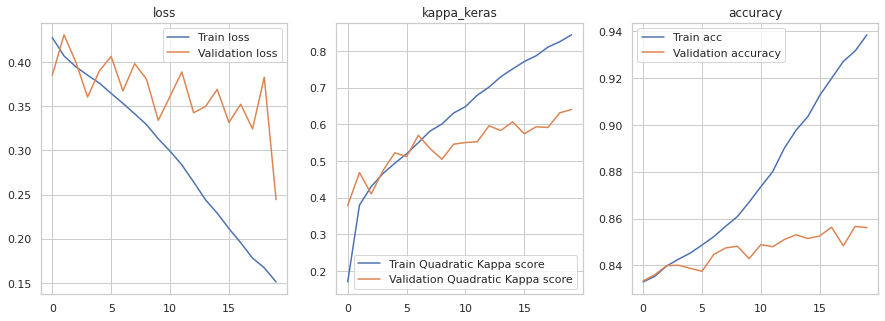

In [36]:
show_history(hist_vgg19)

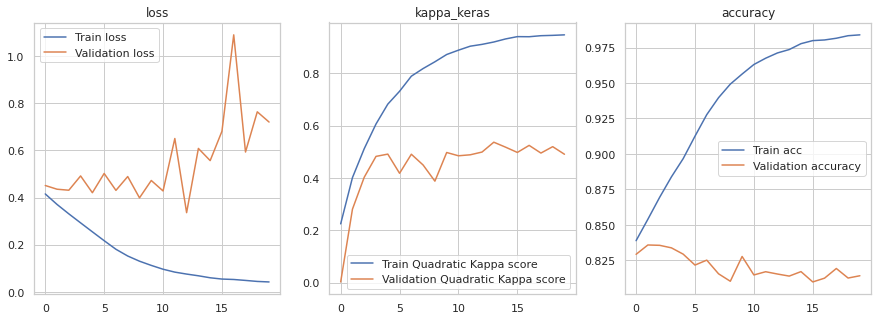

In [37]:
show_history(hist_Resnet)

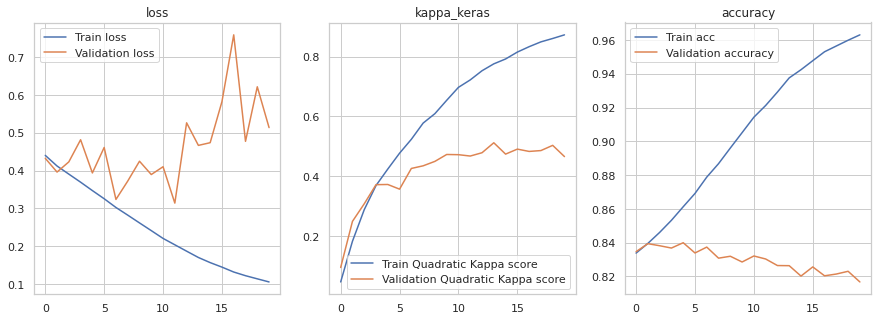

In [38]:
show_history(hist_Densenet)

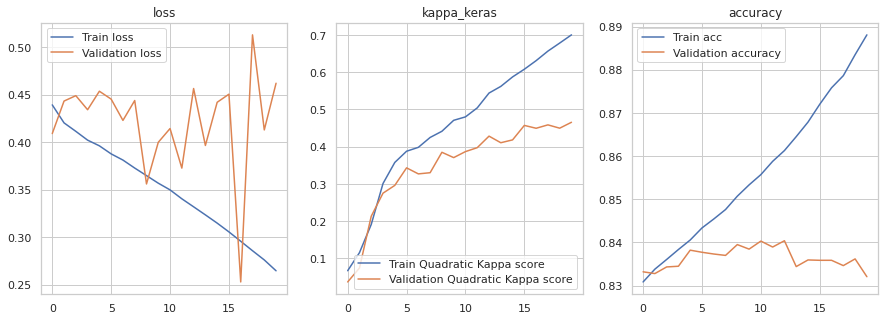

In [39]:
show_history(hist_Inception)

## Save Model

In [40]:

VGG19_baseline = vgg19_conv.save('vgg19_Baseline.h5')  
Resnet50_baseline = ResNet50_conv.save('resnet50_Baseline.h5')
InceptionV3_baseline = InceptionV3_conv.save('inceptionV3_Baseline.h5')
Densenet_baseline = Densenet_conv.save('densenet_Baseline.h5')

## Save weight

In [41]:
VGG19_weights = vgg19_conv.save_weights('vgg19_weights.h5')  
Resnet50_weights = ResNet50_conv.save_weights('resnet50_weights.h5')
InceptionV3_weights = InceptionV3_conv.save_weights('inceptionV3_weights.h5')
Densenet_weights = Densenet_conv.save_weights('densenet_weights.h5')

## Predict


In [54]:
def predict_submission(df, path, passes=1):
    
    df["image_path"] = [path+image_id+".tiff" for image_id in df["image_id"]]
    df["isup_grade"] = 0
    
    for idx, row in df.iterrows():
        prediction_per_pass = []
        for i in range(passes):
            model_input = np.array([get_random_samples(row.image_path)/255.])
            input_image1 = model_input[:,0,:,:]
            input_image2 = model_input[:,1,:,:]
            input_image3 = model_input[:,2,:,:]

            prediction = vgg19_conv.predict([input_image1,input_image2,input_image3])
            prediction_per_pass.append(np.argmax(prediction))
            
        df.at[idx,"isup_grade"] = np.mean(prediction_per_pass)
    df = df.drop('image_path', 1)
    return df[["image_id","isup_grade"]]

In [55]:
def predict_submission(df, path):
    
    df["image_path"] = [path+image_id+".tiff" for image_id in df["image_id"]]
    df["isup_grade"] = 0
    predictions = []
    for idx, row in df.iterrows():
        print(row.image_path)
        img=skimage.io.imread(str(row.image_path))
        img = cv2.resize(img, (224,224))
        img = cv2.resize(img, (224,224))
        img = img.astype(np.float32)/255.
        img=np.reshape(img,(1,224,224,3))
       
    
        prediction=vgg19_conv.predict(img)
        predictions.append(np.argmax(prediction))
            
    df["isup_grade"] = predictions
    df = df.drop('image_path', 1)
    return df[["image_id","isup_grade"]]

In [56]:
test_path = "/kaggle/input/test-image/"
submission_df = pd.read_csv("../input/prostate-cancer-grade-assessment/sample_submission.csv")

if os.path.exists(test_path):
    test_df = pd.read_csv("/kaggle/input/test-ss/test.csv")
    submission_df = predict_submission(test_df, test_path)
else:
    print('submission csv not found')

submission_df.to_csv('submission.csv', index=False)
submission_df.head()

/kaggle/input/test-image/006f6aa35a78965c92fffd1fbd53a058.tiff
/kaggle/input/test-image/0032bfa835ce0f43a92ae0bbab6871cb.tiff
/kaggle/input/test-image/00928370e2dfeb8a507667ef1d4efcbb.tiff


,image_id,isup_grade
0,006f6aa35a78965c92fffd1fbd53a058,3
1,0032bfa835ce0f43a92ae0bbab6871cb,1
2,00928370e2dfeb8a507667ef1d4efcbb,5
